<h1 align="center"> Credit Scoring  </h1>

First of all, Thank you for your interest in my notebook. If you feel useful please upvote for me. Thank you for your consideration.

# Introduction
>  " *A credit score is a numerical expression based on a level analysis of a person's credit files, to represent the creditworthiness of an individual. A credit score is primarily based on a credit report, information typically sourced from credit bureaus.Lenders, such as banks and credit card companies, use credit scores to evaluate the potential risk posed by lending money to consumers and to mitigate losses due to bad debt. Lenders use credit scores to determine who qualifies for a loan, at what interest rate, and what credit limits. Lenders also use credit scores to determine which customers are likely to bring in the most revenue. The use of credit or identity scoring prior to authorizing access or granting credit is an implementation of a trusted system.Credit scoring is not limited to banks. Other organizations, such as mobile phone companies, insurance companies, landlords, and government departments employ the same techniques. Digital finance companies such as online lenders also use alternative data sources to calculate the creditworthiness of borrowers.* " [1]

Overview of my solution
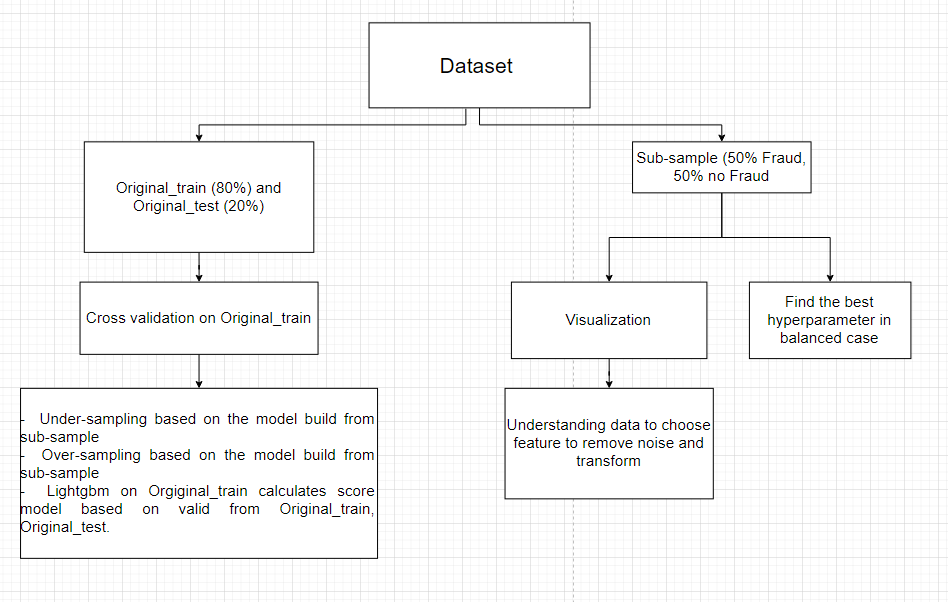
# Outline

# [I. Preprocess](#preprocess)

   * [1,1. Replace mising value](#replace)
   * [1.2. Split data](#split)
   * [1.3. Robust transform](#robust)
   
# [II. Visualization](#visual)
   * [2.1. Heat map](#corre) 
   * [2.2. Boxplot](#boxplot)

# [III. OUTLIER-DETECTION](#out)
    
   * [3.1. Why do we use Tukey's method ?](#turkey)
   * [3.2. TUKEY’S METHOD](#wturkey)
   
# [IV. Algorithm](#algo)

   * [4.1. Classifiers (Knn, Logistic regression, Naive Bayes, Random Forest, Decision Tree)](#class)
   * [4.2. Random Undersampling](#under)
   * [4.3. Random Oversampling](#over)
   * [4.4. Lightgbm](#light)
[1]: https://en.wikipedia.org/wiki/Credit_score


In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import auc, precision_recall_curve
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve
from imblearn.pipeline import Pipeline
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
import pandas as pd
data = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-training.csv',index_col=0)
test = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-test.csv',index_col=0)
test = test.drop(columns=['SeriousDlqin2yrs'])
test_index = test.index

In [ ]:
data.head()

-  With pandas building  function, We can see that there are 29731 missing value in 'MonthlyIncome' and 3924 missing in 'NumberOfTime60-89DaysPastDueNotWorse'

In [ ]:
data.isnull().sum()

# Preprocessing <a id="preprocess"></a>

## Replace mising value <a id="replace"></a>
- To avoid changing the standard deviation, I will use the mean of each column to fill in the missing values

In [ ]:
data.NumberOfDependents.fillna(data.NumberOfDependents.mean(),inplace=True)
data.MonthlyIncome.fillna(data.MonthlyIncome.mean(),inplace=True)
test.NumberOfDependents.fillna(test.NumberOfDependents.mean(),inplace=True)
test.MonthlyIncome.fillna(test.MonthlyIncome.mean(),inplace=True)

## Split data <a id="split"></a>
- Sub-sampling: Take a part of the data with the same label (same ratio Fraud and no Fraud) to understand data. Because of the data heavily imbalanced so correlation gets the wrong value for each other. 
- Cross-validation of data to evaluation my model.

- The dataset are used in this notebook was heavily imbalanced

In [ ]:
print('No Frauds', round(data['SeriousDlqin2yrs'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['SeriousDlqin2yrs'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

In [ ]:
sns.countplot('SeriousDlqin2yrs', data=data, palette=["#0101DF", "#DF0101"])
# plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=12)

- Split train-test has the same percent of each label.

In [ ]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(data, data['SeriousDlqin2yrs'], test_size=0.2, random_state=42)

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')

print('distribution of original_ytrain ')
print(train_counts_label/ len(original_ytrain))

print('distribution of original_ytest')
print(test_counts_label/ len(original_ytest))

- Now, I create sub-samples from the data with the balancing in the label to observe the data correlation

## Why do we create sub-sample before visualization ?
- we see that the my data was heavily imbalanced! 
- Using the original dataset will cause the following issues:

    ** Overfitting **: My model will assume that in most cases there are no frauds. Leading to the parameter is not optimize.
    
    ** Wrong Correlations**: The majority class heavily impacts the class. we are not able to see the true correlations between the classes and features.

In [ ]:
data = data.sample(frac=1)
fraud = data.loc[data['SeriousDlqin2yrs'] == 1]

no_fraud = data.loc[data['SeriousDlqin2yrs'] == 0][:len(fraud)]

sub_sample = pd.concat([fraud,no_fraud])
sub_sample = sub_sample.sample(frac=1,random_state = 42)

In [ ]:
colors = ["#0101DF", "#DF0101"]

In [ ]:
sns.countplot('SeriousDlqin2yrs', data=sub_sample)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=12)

# II. Visualization <a id="visual"></a>

## 2.1. Heatmap <a id="corre"></a>

Notice: The goal we want to predict is **SeriousDlqin2yrs**

In [ ]:
sub_sample.head()

In [ ]:
sub_sample.isnull().sum().max()

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(sub_sample.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

- **Negative Correlations:** age, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, If the features has lower these value then more likely the end result will be a fraud transaction.
- **Possitive Correlations** NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfDependents, If that feature has higher these value then more likely the end result will be a fraud transaction.

In [ ]:
sub_sample.columns

## 2.2. Boxplot <a id="boxplot"></a> 

In [ ]:
f, axes = plt.subplots(ncols=2, nrows=3, figsize=(20,15))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="SeriousDlqin2yrs", y="age", data=sub_sample, palette=colors, ax=axes[0][0])
axes[0][0].set_title('age vs Class Negative Correlation')

sns.boxplot(x="SeriousDlqin2yrs", y="MonthlyIncome", data=sub_sample, palette=colors, ax=axes[0][1])
axes[0][1].set_title('MonthlyIncome vs Class Negative Correlation')


sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfOpenCreditLinesAndLoans", data=sub_sample, palette=colors, ax=axes[1][0])
axes[1][0].set_title('NumberOfOpenCreditLinesAndLoans vs Class Negative Correlation')

sns.boxplot(x="SeriousDlqin2yrs", y="DebtRatio", data=sub_sample, palette=colors, ax=axes[1][1])
axes[1][1].set_title('DebtRatio vs Class Negative Correlation')

sns.boxplot(x="SeriousDlqin2yrs", y="NumberRealEstateLoansOrLines", data=sub_sample, palette=colors, ax=axes[2][0])
axes[2][0].set_title('NumberRealEstateLoansOrLines vs Class Negative Correlation')


sns.boxplot(x="SeriousDlqin2yrs", y="NumberRealEstateLoansOrLines", data=sub_sample, palette=colors, ax=axes[2][1])
axes[2][1].set_title('NumberRealEstateLoansOrLines vs Class Negative Correlation')

plt.show()

In [ ]:
f, axes = plt.subplots(ncols=2,nrows=2,figsize=(15,10))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfTime30-59DaysPastDueNotWorse", data=sub_sample, palette=colors, ax=axes[0][0])
axes[0][0].set_title('NumberOfTime30-59DaysPastDueNotWorse vs Class Negative Correlation')

sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfTimes90DaysLate", data=sub_sample, palette=colors, ax=axes[0][1])
axes[0][1].set_title('NumberOfTimes90DaysLate vs Class Negative Correlation')

sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfTime60-89DaysPastDueNotWorse", data=sub_sample, palette=colors, ax=axes[1][0])
axes[1][0].set_title('NumberOfTime60-89DaysPastDueNotWorse vs Class Negative Correlation')


sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfDependents", data=sub_sample, palette=colors, ax=axes[1][1])
axes[1][1].set_title('NumberOfDependents vs Class Negative Correlation')

plt.show()

-  According to these boxplot, some features like: 'NumberOfDependents','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','age' have the same distribution on the class so that My model hardly for identify these class based on this feature. But It has a large value so it impacts other important features. I apply a log transform on it.

- According to these boxplot, some features like: 'NumberOfDependents','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','age' are important to class.
- The important features have more information to identify the class of the class, It is important for my model. So I applied a Turkey method to remove outlier from important feature.

In [ ]:
scale2 = ['DebtRatio','NumberOfTimes90DaysLate','DebtRatio','MonthlyIncome']
for col in scale2:
    sub_sample[col] = sub_sample[col].map(lambda x:np.log(x) if x>0 else 0 )

- Apply to private test

In [ ]:
scale2 = ['DebtRatio','NumberOfTimes90DaysLate','DebtRatio','MonthlyIncome']
for col in scale2:
    test[col] = test[col].map(lambda x:np.log(x) if x>0 else 0 )

# III. OUTLIER-DETECTION <a id="out"></a>

## 3.1. Why do we use Tukey's method ? <a class="anchor" id="turkey" ></a> 
   
   * The dataset is very large(~250000 rows),
   * Data are heavily skewed in a some feature. 
   * Tukey’s method is applicable to skewed or non mound-shaped data since it makes no distributional assumptions and it does not depend on the mean or standard deviation.

## 3.2. TUKEY’S METHOD <a class="anchor" id="wturkey" ></a>
   ![](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Empirical_Rule.PNG/350px-Empirical_Rule.PNG)   
    
   * The plot shows that about 68%,95%, and 99.7% of the data from a normal distribution are within 1, 2, and 3 standard deviations of the mean, respectively[3].
   * Tukey method depend on a mean or standard deviation of the data. 
   * The plot from [wikimedia commons][4] shows for us Tukey's method work into the data.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/550px-Boxplot_vs_PDF.svg.png)    
   * The lower quartile (Q1) is the 25th percentile, and the upper quartile (Q3) is the 75th percentile of the data.
   * The IQR (Inter Quartile Range) is the distance between the lower (Q1) and upper (Q3) quartiles.
   * Inner fences are located at a distance 1.5 IQR below Q1 and above Q3 [Q1-1.5 IQR,Q3+1.5IQR].
   * Further information can be found in [book][3].
   
[1]: https://en.wikipedia.org/wiki/Medcouple
[2]: https://github.com/tks1998/statistical-function-and-algorithm-ML-/blob/master/medcople.py
[3]: http://d-scholarship-dev.library.pitt.edu/7948
[4]: https://commons.wikimedia.org/wiki/File:Boxplot_vs_PDF.svg
[5]: https://www.statisticshowto.com/probability-and-statistics/skewed-distribution/        

- In my function, I remove data on this important feature based on Turkey's method

In [ ]:
def detection_outlier(df,cols):
    
    outlier_indices = np.array([])
    
    for col in cols:
        Q1 = np.percentile(df[col],25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices = np.append(outlier_indices,outlier_list_col.values)         
    return np.unique(outlier_indices)

In [ ]:
special_column = ['NumberOfDependents','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','age']
index_outlier_sub_sample = detection_outlier(sub_sample,special_column)

In [ ]:
index_outlier_sub_sample.shape

In [ ]:
x_sub_sample = sub_sample.drop(index_outlier_sub_sample, axis = 0).reset_index(drop=True)
y_sub_sample = sub_sample['SeriousDlqin2yrs']

In [ ]:
f, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="SeriousDlqin2yrs", y="age", data=x_sub_sample, palette=colors, ax=axes[0][0])
axes[0][0].set_title('age vs Class Negative Correlation')

sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfDependents", data=x_sub_sample, palette=colors, ax=axes[0][1])
axes[0][1].set_title('NumberOfDependents vs Class Negative Correlation')

sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfTime30-59DaysPastDueNotWorse", data=x_sub_sample, palette=colors, ax=axes[1][0])
axes[1][0].set_title('NumberOfTime30-59DaysPastDueNotWorse vs Class Negative Correlation')

sns.boxplot(x="SeriousDlqin2yrs", y="NumberOfTime60-89DaysPastDueNotWorse", data=x_sub_sample, palette=colors, ax=axes[1][1])
axes[1][1].set_title('NumberOfTime60-89DaysPastDueNotWorse vs Class Negative Correlation')

plt.show()

- Apply the method to original train. 

In [ ]:
index_outlier = detection_outlier(original_Xtrain,special_column)

In [ ]:
scale2 = ['DebtRatio','NumberOfTimes90DaysLate','DebtRatio','MonthlyIncome']
for col in scale2:
    original_Xtrain[col] = original_Xtrain[col].map(lambda x:np.log(x) if x>0 else 0 )

In [ ]:
x_sub_sample = sub_sample.drop(columns=['SeriousDlqin2yrs'])
y_sub_sample = sub_sample['SeriousDlqin2yrs']

original_Xtrain = original_Xtrain.drop(columns=['SeriousDlqin2yrs'], axis = 1).reset_index(drop=True)
original_Xtest  = original_Xtest.drop(columns=['SeriousDlqin2yrs'], axis = 1).reset_index(drop=True)

private_test    = test.values
original_Xtrain = original_Xtrain.values 
original_Xtest =  original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# IV. Algorithm <a id="algo"></a>

## 4.1 Classifiers (Knn, Logistic regression, Naive Bayes, Random Forest, Decision Tree)<a id="class"></a>

- Holding indicates of the train test and valid test compare each other algorithm

In [ ]:
num_round = 5
kfold = StratifiedKFold(n_splits=num_round, random_state=None, shuffle=False)
id =0
split_data ={}
for train,test in kfold.split(original_Xtrain,original_ytrain):
    split_data['train'+str(id)] = train
    split_data['valid'+str(id)] = test
    id+=1

- Now, I'm training sub-sampling, this purpose method find the best parameter to apply to orther algorithm

In [ ]:
clssifers ={
    "LogisticRegression" : LogisticRegression(max_iter = 10000),
    "RandomForestClassifier" : RandomForestClassifier(),
    "GaussianNB": GaussianNB(),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [ ]:
for key,clf in clssifers.items():
    clf.fit(x_sub_sample,y_sub_sample)
    score = cross_val_score(clf,x_sub_sample,y_sub_sample,cv = 5,scoring='roc_auc')
    print(key,'score',round(score.mean(),2))
    

I use GridSearchCV for sklearn to find the best parameter.

In [ ]:
def find_best_parameter(clf,parameter,X_train,y_train):
    best_model = GridSearchCV(clf,parameter).fit(X_train,y_train)
    return best_model.best_estimator_

In [ ]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {'C': [0.01, 0.1, 1]}
log_clf = find_best_parameter(LogisticRegression(max_iter = 10000), log_reg_params,x_sub_sample,y_sub_sample)

#Knn n_neighbors must odd number
knears_params = {"n_neighbors": list(range(1,5,2)), 'algorithm': ['ball_tree', 'kd_tree']}

knn_clf = find_best_parameter(KNeighborsClassifier(), knears_params,x_sub_sample,y_sub_sample)



In [ ]:
# save new parameter
clssifers['KNearest'] = knn_clf  
clssifers['LogisticRegression'] = log_clf  

## 4.2. Undersampling <a id="under"></a>

- Undersampling method during Cross Validation
- Randomly delete examples in the majority class. Random undersampling involves randomly selecting examples from the majority class and deleting them from the training dataset. The puporse to balance data after that fit it to my model.
- The results are average k fold validation on valid test, original test.

In [ ]:
X_nearmiss, y_nearmiss = NearMiss().fit_sample(original_Xtrain, original_ytrain)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
p = {} # save result
for key,clf in clssifers.items():
    pres = 0.0
    averager_pre =[]
    id = 0
    for id in range(0,num_round):
        # get index train and valid
        train_id = split_data['train'+str(id)]
        valid_id = split_data['valid'+str(id)]
        id+=1
        # fit model
        undersample_pipeline    = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), clf) 
        undersample_model       = undersample_pipeline.fit(original_Xtrain[train_id], original_ytrain[train_id])
        
        # calculate score
        result  = undersample_model.predict(original_Xtrain[valid_id])
        pres += result/num_round
    for value in pres:
        if value>.5:
            averager_pre.append(1)
        else:
            averager_pre.append(0)
    p[key] = metrics.confusion_matrix(averager_pre,original_ytrain[valid_id])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix(p['LogisticRegression'],['non-Fraud','Fraud'])

In [ ]:
plot_confusion_matrix(p['RandomForestClassifier'],['non-Fraud','Fraud'])

In [ ]:
plot_confusion_matrix(p['GaussianNB'],['non-Fraud','Fraud'])

Summary : 
- The result is an average of 5 fold. 
- In this case, I implement undersampling to get bad results with classifiers. I think the undersampling method lost a lot of information from data and my preprocessing not good for the undersampling algorithm. 

## 4.3. Oversampling <a id="over"></a>

* Oversampling method during Cross-Validation
- Notice: We must split the train and test after that using an oversample. Unless We get overfit because the oversampling method creates the value based on my data. When I separate data, data generated from the oversampling method can appear in both training and testing.
### The Wrong Way:
  <img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401"><br>
### The right ways:
  <img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372"> <br>

In [ ]:
def transform_average_result(pres):
    averager_pre = []
    for value in pres:
        if value>.5:
            averager_pre.append(1)
        else:
            averager_pre.append(0)
    return averager_pre

In [ ]:

# Implementing SMOTE Technique 
# Cross Validating the right way

result_valid  = {} # save result
result_orginal = {}
private_test_result = {}
for key,clf in clssifers.items():
    average_original_test = 0.0
    average_valid_test = 0.0
    average_private_test = 0.0
    for id in range(0,num_round):
        # get index train and valid
        train_id = split_data['train'+str(id)]
        valid_id = split_data['valid'+str(id)]
        # apply Smote() 
        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'),RandomForestClassifier()) # SMOTE happens during Cross Validation not before..
        model = pipeline.fit(original_Xtrain[train_id], original_ytrain[train_id])
        
        # predict 
        score_valid_test = model.predict(original_Xtrain[valid_id])
        score_original_test = model.predict(original_Xtest)
        score_private_test = model.predict_proba(private_test)
        
        ## average 5 round
        average_valid_test     += score_valid_test/num_round
        average_original_test  += score_original_test/num_round
        average_private_test   += score_private_test/num_round
    
    # transform probability to class
    valid  = transform_average_result(average_valid_test)
    orginal = transform_average_result(average_original_test)
    
    ## save result in cross validation
    result_valid[key] = metrics.confusion_matrix(valid,original_ytrain[valid_id])
    result_orginal[key] = metrics.confusion_matrix(orginal,original_ytest)
    
    ## The result probability predict private test save to dict private_test_result
    private_test_result[key] = average_private_test


- The result original_test on Knn and LogisticRegression approx 90% accuracy. We observed the results in the confusion matrix below.

In [ ]:
plot_confusion_matrix(result_orginal['LogisticRegression'],['non-Fraud','Fraud'])

In [ ]:
plot_confusion_matrix(result_orginal['KNearest'],['non-Fraud','Fraud'])

In [ ]:
print("private test with knn algorithm ")
private_test_result['KNearest'][:,1]

In [ ]:
print("private test with Logistic Regression algorithm")
private_test_result['LogisticRegression'][:,1]

In [ ]:
result = pd.DataFrame({'Id': test_index,'Probability': private_test_result['LogisticRegression'][:,1]})
result.to_csv('result.csv',index=0)

Summary: 
- I get approx 91% accuracy and miss approx 0.08% class Fraud, The result is better than undersampling.
- I submit a private test with two algorithms Knn and logistic receive 80% and 81% roc_auc score, respectively. 

# 4.4. Lightgbm <a id="light"></a>

- In recent years, Lightgbm is a famous model and is used in many Kaggle competitions. And I decide to apply for the problems. 
- I use 5-Cross-validation on original_Xtrain. I tested it on a valid-test and Original-test result has 94% accuracy. I submit results get an 85% private test and 84% public test. We can see more information confusion matrix below.

In [ ]:
params = {
    'objective'         : 'binary',    
    'metric'            : 'auc', 
    'nthread'           : 4,
    'learning_rate'     : 0.01, 
    'num_leaves'        : 23,
    'feature_fraction'  : 0.106,
    'bagging_fraction'  : 0.825,
    'max_depth'         : -1,
    'lambda_l1'         : 0.2,
    'lambda_l2'         : 2.7,
    'min_split_gain'    : 0.007,
}

In [ ]:

preds_valid = 0.0
preds_origin_test = 0.0
preds_private_test = 0.0
accuracy_valid = []
f1_valid = []
for id in range(0,num_round):
    ## get index train && test set 
    train_id = split_data['train'+str(id)]
    valid_id = split_data['valid'+str(id)]

    ## build model
    lgb_train = lgb.Dataset(original_Xtrain[train_id], original_ytrain[train_id])
    
    lgb_eval  = lgb.Dataset(original_Xtrain[valid_id], original_ytrain[valid_id], reference = lgb_train)
    
    model = lgb.train(params,
                lgb_train,
                num_boost_round = 99999,  
                early_stopping_rounds = 800,
                verbose_eval = False,
                valid_sets = [lgb_train, lgb_eval])
    
    # valid test
    pred_valid = model.predict(original_Xtrain[valid_id])
    
    trans_class = transform_average_result(pred_valid)
    accuracy_valid.append(metrics.accuracy_score(trans_class,original_ytrain[valid_id]))
    f1_valid.append(metrics.f1_score(trans_class,original_ytrain[valid_id]))
    
    # apply original test
    pred_origin_test = model.predict(original_Xtest)
    preds_origin_test += pred_origin_test/num_round
    
    # apply private test
    pred_private_test = model.predict(private_test)
    preds_private_test += pred_private_test/num_round


- Calculate score: average of accuracy and f1 score on validation test.
- Look at the result, I think f1_valid lower because of my model wrong some case in the class Fraud. 
- The result 5 rounds in validation test.

In [ ]:
for value in accuracy_valid:
    print("probability transcation fall in Fraud: ",value)

In [ ]:
for value in f1_valid:
    print("probability transcation fall in Fraud: ",value)

- Testing model in the Original Test receives ~ 93% accuracy and wrong 6.36% class.

In [ ]:
cm = metrics.confusion_matrix(transform_average_result(preds_origin_test),original_ytest)
plot_confusion_matrix(cm,['non-Fraud','Fraud'])

- Submit private test I receive 85.5% roc_auc score. 

In [ ]:
preds_private_test

In [ ]:
result = pd.DataFrame({'Id': test_index,'Probability': preds_private_test})
result.to_csv('result.csv',index=0)

# Summary:
- The main problems we dealing is imbalanced data.
- Create sub-sampling for understanding data.
- Oversampling and Undersampling are famous algorithms apply to imbalanced data. But We more carefully apply it with cross-validation
- Lightgbm is a strong algorithm, but We need to find the best parameter to high performance it takes a long time. 

# References: 
1. https://en.wikipedia.org/wiki/Credit_score 
2. https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets
3. https://www.statisticshowto.com/probability-and-statistics/skewed-distribution/    
4. https://scikit-learn.org/stable/
5. https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation
